In [1]:
# Plots the spectrum of the balanced extraction on the synthetic data (Fig. 6 c)
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import jws_swot_tools as swot  

t = swot.Timer()

PICKLES_DIR = "../pickles"
KARIN_PKL   = f"{PICKLES_DIR}/karin_NA_tmean.pkl"
SIGMA_KM    = 1 
TIME_INDEX  = 6  

OUTNAME     = f"balanced_extraction_NA_tmean_sm_{SIGMA_KM}km"
P_FILE      = f"{PICKLES_DIR}/posterior_{OUTNAME}.pkl" # posterior
CMEAN_FILE  = f"{PICKLES_DIR}/Cmean_{OUTNAME}.pkl" # covariance
HT_ALL_FILE = f"{PICKLES_DIR}/{OUTNAME}.pkl"     # this stores ht_all (t, ny, nx)
OUT_FIG     = f"balanced_spectrum_{SIGMA_KM}km.pdf"

# --- load ---
with open(KARIN_PKL, "rb") as f:
    karin_NA = pickle.load(f)
with open(P_FILE, "rb") as f:
    P = pickle.load(f)
with open(CMEAN_FILE, "rb") as f:
    C_mean = pickle.load(f)

with open(HT_ALL_FILE, "rb") as f:
    ht_all = np.asarray(pickle.load(f)) 
ht_map_2d = ht_all[TIME_INDEX] # balanced extraction

t.lap("Loaded files")

eye = np.eye(P.shape[0], dtype=P.dtype)
L_P    = np.linalg.cholesky(P + 1e-8*eye)
L_mean = np.linalg.cholesky(C_mean + 1e-8*eye)

t.lap("Choleskys done")

def power_spec_1d(field_flat):
    nyt = karin_NA.y_coord_km.size
    nxt = karin_NA.x_coord_km.size
    f2d = np.array(field_flat).reshape((nyt, nxt), order="C")
    da = xr.DataArray(
        f2d[None, :, :],
        coords=[[0], karin_NA.y_coord_km, karin_NA.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr = swot.mean_power_spectrum(da, karin_NA.window, 'line', ['sample', 'pixel'])
    half = int(karin_NA.track_length // 2)
    spec_vals = np.asarray(spec_xr[half:])
    if spec_vals.size != karin_NA.wavenumbers_cpkm.size:
        spec_vals = spec_vals[:karin_NA.wavenumbers_cpkm.size]
    return spec_vals

rng = np.random.default_rng(42)
nreal = 20
spec_unc  = []
spec_mean = []

for _ in range(nreal):
    z  = rng.standard_normal(P.shape[0])
    zm = rng.standard_normal(C_mean.shape[0])

    eps = L_P @ z
    eta = L_mean @ zm

    spec_unc.append(power_spec_1d(eps))
    spec_mean.append(power_spec_1d(eta))

spec_unc  = np.asarray(spec_unc)
spec_mean = np.asarray(spec_mean)

spec_mean_uncertainty = np.nanmean(spec_unc, axis=0)
spec_mean_of_mean     = np.nanmean(spec_mean, axis=0)

t.lap("Spectra generated")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Starting balanced extraction


ModuleNotFoundError: No module named 'JWS_SWOT_toolbox'

┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


In [2]:
ssh_full_map_2d = karin_NA.ssha_full[TIME_INDEX, :, 5:65]
spec_ssh_full = power_spec_1d(ssh_full_map_2d*100)

ssh_noisy = karin_NA.ssh_noisy[TIME_INDEX]
spec_ssh_noisy = power_spec_1d(ssh_noisy*100)

ext_ssh = ht_all[TIME_INDEX]
spec_ext_ssh = power_spec_1d(ext_ssh * 100)

# Simulation
k_karin = karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]
k_km = k_karin[1:]
spec_k_ins = karin_NA.spec_alongtrack_ins[TIME_INDEX][int(karin_NA.track_length/2):][1:]

/scratch/jskinner1/job_44152237/ipykernel_3620421/4004854812.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


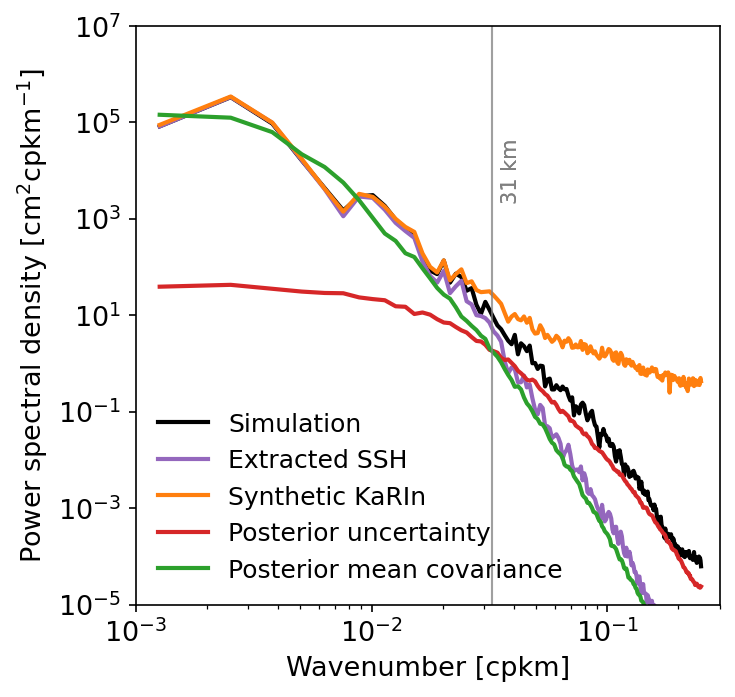

In [13]:
# --- plot ---
fig, ax = plt.subplots(figsize=(5, 5), dpi=150, constrained_layout=True)
ax.loglog(k_km, spec_ssh_full[1:],  lw=2, color = 'k', label='Simulation')
ax.loglog(k_km, spec_ext_ssh[1:], '-', lw=2, color='tab:purple',   label='Extracted SSH')
ax.loglog(k_km, spec_ssh_noisy[1:], '-', lw=2, color='tab:orange', label='Synthetic KaRIn')
ax.loglog(k_km, 0.5*spec_mean_uncertainty[1:],  lw=2, color='tab:red', label='Posterior uncertainty')
ax.loglog(k_km, 0.5*spec_mean_of_mean[1:],  lw=2, color='tab:green', label='Posterior mean covariance')

for Lkm in (31, 31):
    ax.axvline(1.0/Lkm, lw=1.0, alpha=0.5, color='grey')
    ax.text(1.0/Lkm*1.1, 1e4, f"{Lkm} km", rotation=90, color='grey',
            fontsize=10, va='center', ha='left')

ax.set_xlabel('Wavenumber [cpkm]', fontsize=13)
ax.set_ylabel('Power spectral density [cm$^2$cpkm$^{-1}$]', fontsize=13)
ax.set_xlim(1e-3, 3e-1)
ax.set_ylim(1e-5, 1e7)
ax.legend(loc='lower left', fontsize=12, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('spec_synth_ext.pdf')
plt.show()